In [1]:
import torch
import numpy as np
import autoroot
import os
import os.path as osp
import matplotlib.pyplot as plt
from src.distributions import MIMOFadingAWGNDistribution
from torch.distributions import Normal
import matplotlib.animation as animation
import matplotlib.patches as patches
import functools
from src.utils import mimoawgn_capacity

import scienceplots

plt.style.use(['science','ieee'])
plt.rcParams.update(
    {
        # "font.family": "serif",
        "font.serif": "Times New Roman",
        # "font.weight": "normal",
        # "figure.autolayout": False,
        # "figure.titlesize": 40,
        # "lines.linewidth": 6,
        "figure.dpi": 300,
        # "font.size": 8,
        # "figure.figsize": (4, 3),
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{bm,amsmath,amsfonts}",
    },
)
figsize = plt.rcParams["figure.figsize"]

root_dir = os.environ['PROJECT_ROOT']

In [2]:
def get_logs(log_dir, dim_x, dim_y, num_samples_x, snr_list):

    log_list = []
    capacity_true_list = []
    rate_list = []
    cost_list = []
    covx_list = []
    
    for snr in snr_list:
        log_path = osp.join(log_dir, f'{dim_x}_{dim_y}/{snr}_{num_samples_x}', 'logs.npz')
        logs = dict(np.load(log_path))
        log_list.append(logs)
        idx = -1
        H = logs['channel_mat']
        cost = logs['cost'][idx]
        cost_list.append(cost)
        
        rate = logs['rate'][idx]
        rate_list.append(rate * np.log2(np.e))
        
        capacity_true, covx = mimoawgn_capacity(H, 10 * np.log10(cost))
        capacity_true_list.append(capacity_true)
        covx_list.append(covx)
        
    return log_list, capacity_true_list, rate_list, cost_list, covx_list


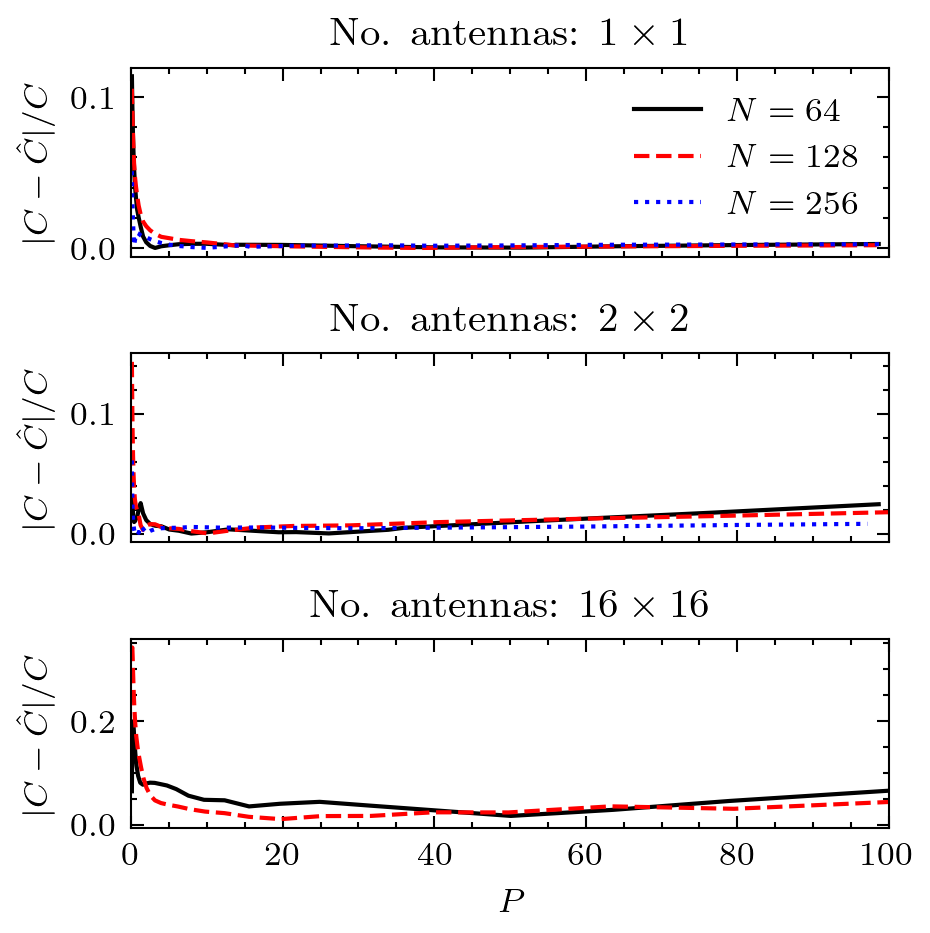

In [3]:
log_dir = osp.join(root_dir, 'logs', 'mimoawgn', 'multiruns')
num_samples_x_list = [64, 128, 256]
snr_list = np.arange(-10, 21, 1)
fig, ax = plt.subplots(3, 1, figsize = (figsize[0], figsize[1]*1.3), sharex=True)

for i, dim_x in enumerate([1, 2, 16]):
    dim_y = dim_x
    for num_samples_x in num_samples_x_list:
        if dim_x == 16 and num_samples_x == 256:
            continue
        log_list, capacity_true_list, rate_list, cost_list, covx_list = get_logs(log_dir, dim_x, dim_y, num_samples_x, snr_list)
        capacity_true_array = np.array(capacity_true_list)
        rate_array = np.array(rate_list)
        ax[i].plot(cost_list, np.abs(capacity_true_array - rate_array)/capacity_true_array, label=f'$N={num_samples_x}$')
        
    ax[i].set_xlim([0, 100])
    ax[i].set_ylabel(r'$|C - \hat{C}|/C$')
    # ax[i].set_yscale('log')
    ax[i].set_title(fr'No. antennas: ${dim_x}\times{dim_x}$')
    
ax[0].legend()
ax[-1].set_xlabel('$P$')
fig.tight_layout()
fig.savefig(osp.join(root_dir, 'figures', 'mimoawgn_capacity_error.pdf'))

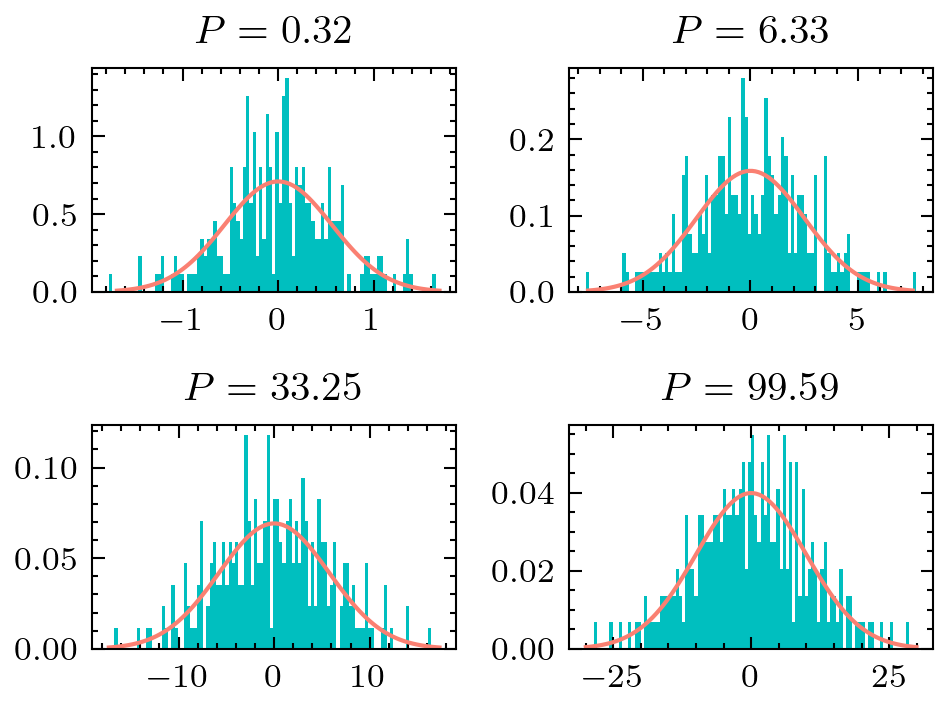

In [4]:
num_samples_x = 256
dim_y = dim_x = 1

log_list, capacity_true_list, rate_list, cost_list, covx_list = get_logs(log_dir, dim_x, dim_y, num_samples_x, snr_list)

fig, axes = plt.subplots(2, 2)

for i, idx in enumerate([5, 18, 25, -1]):
    ax = axes.flatten()[i]
    x = log_list[idx]['x'][-1]
    sigma = np.sqrt(cost_list[idx])
    t = torch.linspace(-3* sigma, 3*sigma, 100)
    p = Normal(0, sigma).log_prob(t).exp().numpy()
    ax.hist(x, bins=100, density=True, color='c')
    ax.plot(t, p, color='salmon')
    ax.set_title(r'$P = %.2f$' % cost_list[idx])

fig.tight_layout()
fig.savefig(osp.join(root_dir, 'figures', 'sisoawgn_hist.pdf'))

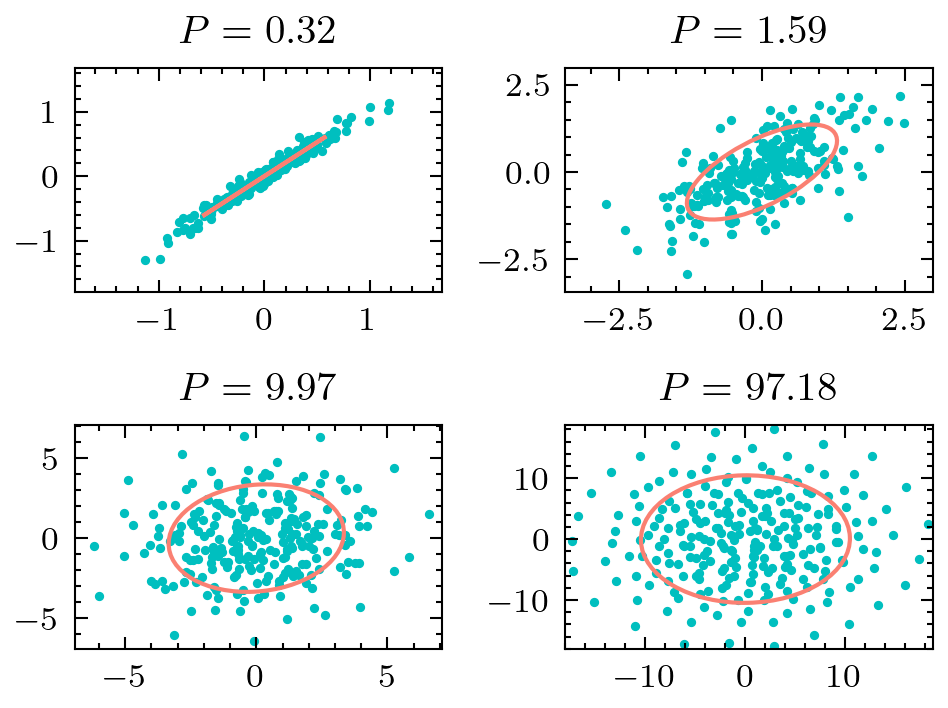

In [5]:
num_samples_x = 256
dim_y = dim_x = 2

log_list, capacity_true_list, rate_list, cost_list, covx_list = get_logs(log_dir, dim_x, dim_y, num_samples_x, snr_list)

fig, axes = plt.subplots(2, 2)

for i, idx in enumerate([5, 12, 20, -1]):
    ax = axes.flatten()[i]
    x = log_list[idx]['x'][-1]
    eigval, eigvec = np.linalg.eigh(covx_list[idx])
    eigval[eigval < 0] = 0
    angle = np.arctan2(eigvec[1,0], eigvec[0,0]) * 180 / np.pi
    width, height = 3 * np.sqrt(eigval)
    ax.scatter(x[:,0], x[:,1], color='c', s=1.5)
    ell = patches.Ellipse((0,0), width, height, angle=angle, fill=False, color='salmon')
    ax.add_patch(ell)
    ax.set_xlim(x.min() - 0.5, x.max() + 0.5)
    ax.set_ylim(x.min() - 0.5, x.max() + 0.5)
    ax.set_title(r'$P = %.2f$' % cost_list[idx])

fig.tight_layout()
fig.savefig(osp.join(root_dir, 'figures', 'mimoawgn_particles.pdf'))

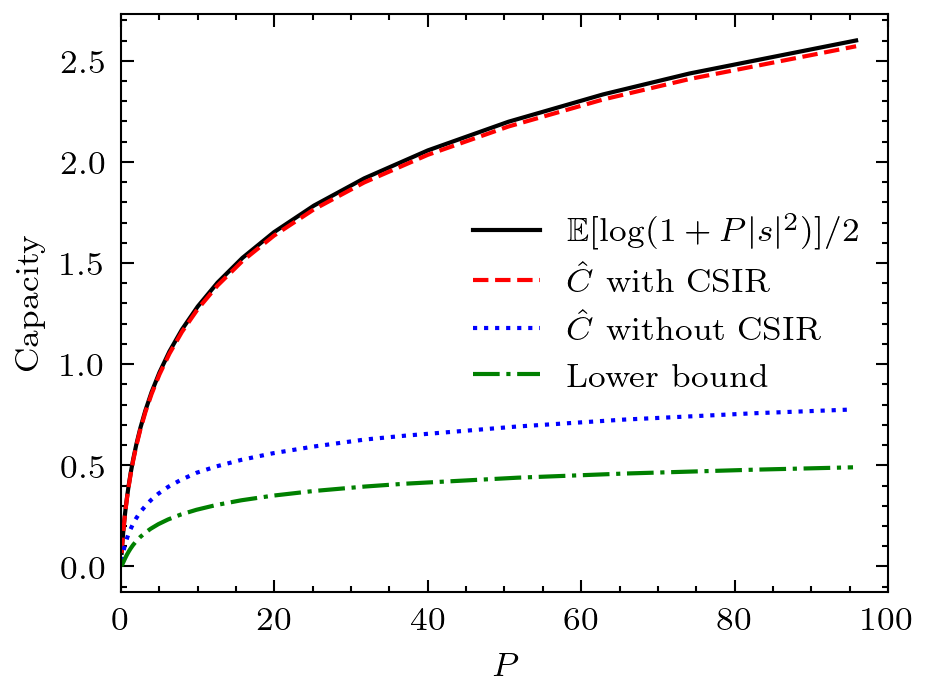

In [13]:
dim_x = 1
dim_y = 1
snr_list = np.arange(-10, 21, 1)

log_dir = osp.join(root_dir, 'logs', 'fading_csir', 'multiruns')

log_list, _, rate_list, cost_list, _ = get_logs(log_dir, dim_x, dim_y, 128, snr_list)

capacity_ub_list = []
capacity_list = []
capacity_lb_list = []

for i, c in enumerate(log_list):
    capacity_ub = log_list[i]['capacity_ub']
    capacity_ub_list.append(capacity_ub.item() * np.log2(np.e))
    
fig, ax = plt.subplots()

ax.plot(cost_list, capacity_ub_list, label=r'$\mathbb{E}[\log(1+P|s|^2)]/2$')
ax.plot(cost_list, rate_list, label=r'$\hat{C}$ with CSIR')
ax.set_xlabel('$P$')
ax.set_ylabel('Capacity')

log_dir = osp.join(root_dir, 'logs', 'fading', 'multiruns')
log_list, _, rate_list, cost_list, _ = get_logs(log_dir, dim_x, dim_y, 64, snr_list)

for i, c in enumerate(log_list):
    capacity_lb = log_list[i]['capacity_lb']
    capacity_lb_list.append(capacity_lb.item() * np.log2(np.e))

ax.plot(cost_list, rate_list, label=r'$\hat{C}$ without CSIR')
ax.plot(cost_list, capacity_lb_list, label=r'Lower bound')
ax.set_xlim([0, 100])

ax.legend()
fig.savefig(osp.join(root_dir, 'figures', 'fading_capacity.pdf'))

P = 0.99561607837677


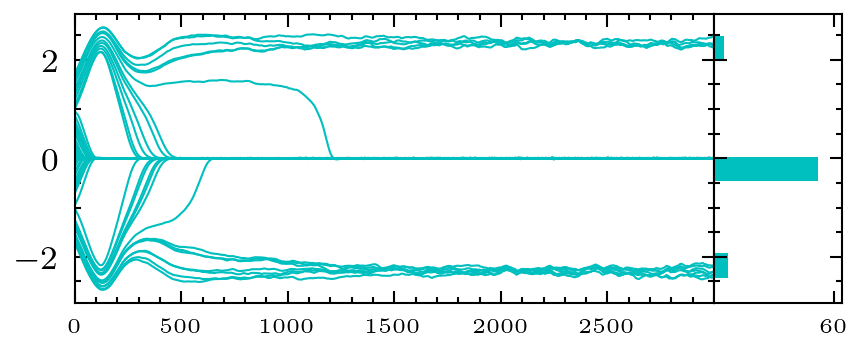

In [84]:
fig = plt.figure(figsize=(figsize[0], figsize[1]/2))
gs = fig.add_gridspec(1, 2,  width_ratios=(5, 1),
                      wspace=0.0)
ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
idx = 10
print(f"P = {cost_list[idx]}")
max_steps = 3000
x = log_list[10]['x'].squeeze()[:max_steps]
for i in range(x.shape[1]):
    ax.plot(x[:,i], 'c-', linewidth=0.5)
ax.set_xlim([0, max_steps])
ax_xticks = ax.get_xticks()
ax.set_xticks(ax_xticks[:-1])
ax.tick_params(axis='x', labelsize=5)
ax_histy.hist(x[-1,:], bins=10, orientation='horizontal', color='c', density=False)
ax_histy.set_xlim([0, 64])
plt.setp(ax_histy.get_yticklabels(), visible=False)
ax_histy_xticks = ax_histy.get_xticks()
ax_histy.set_xticks([60])
ax_histy.tick_params(axis='x', labelsize=5)
fig.savefig(osp.join(root_dir, 'figures', 'fading_particles.pdf'))

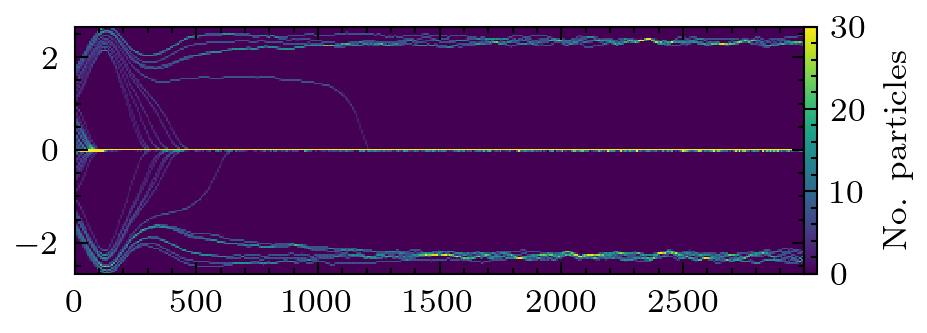

In [78]:
fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]/2))
y = np.arange(x.shape[0]).repeat(x.shape[1]).reshape(-1, x.shape[1])
x_fine = x.ravel()
y_fine = y.ravel()
cmap = plt.colormaps["plasma"]
cmap = cmap.with_extremes(bad=cmap(0))
h, yedges, xedges = np.histogram2d(y_fine, x_fine, bins=[400, 150])
pcm = ax.pcolormesh(yedges, xedges, h.T, 
                         vmax=30, rasterized=True)
fig.colorbar(pcm,label=r"No. particles",pad=0)
fig.tight_layout()
fig.savefig(osp.join(root_dir, 'figures', 'fading_particles_cmap.pdf'))